In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder,StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Input
import joblib
from flask import Flask, request, jsonify
import os
import logging
import pickle

In [2]:
data=pd.read_csv("crime_dataset_india.csv")

In [3]:
data.head()

,Report Number,Date Reported,Date of Occurrence,Time of Occurrence,City,Crime Code,Crime Description,Victim Age,Victim Gender,Weapon Used,Crime Domain,Police Deployed,Case Closed,Date Case Closed
0,1,02-01-2020 00:00,01-01-2020 00:00,01-01-2020 01:11,Ahmedabad,576,IDENTITY THEFT,16,M,Blunt Object,Violent Crime,13,No,NaN
1,2,01-01-2020 19:00,01-01-2020 01:00,01-01-2020 06:26,Chennai,128,HOMICIDE,37,M,Poison,Other Crime,9,No,NaN
2,3,02-01-2020 05:00,01-01-2020 02:00,01-01-2020 14:30,Ludhiana,271,KIDNAPPING,48,F,Blunt Object,Other Crime,15,No,NaN
3,4,01-01-2020 05:00,01-01-2020 03:00,01-01-2020 14:46,Pune,170,BURGLARY,49,F,Firearm,Other Crime,1,Yes,29-04-2020 05:00
4,5,01-01-2020 21:00,01-01-2020 04:00,01-01-2020 16:51,Pune,421,VANDALISM,30,F,Other,Other Crime,18,Yes,08-01-2020 21:00


In [4]:
data.tail()

,Report Number,Date Reported,Date of Occurrence,Time of Occurrence,City,Crime Code,Crime Description,Victim Age,Victim Gender,Weapon Used,Crime Domain,Police Deployed,Case Closed,Date Case Closed
40155,40156,01-08-2024 16:00,07-31-2024 03:00,31-07-2024 05:05,Kolkata,312,COUNTERFEITING,78,F,Firearm,Other Crime,12,No,NaN
40156,40157,31-07-2024 14:00,07-31-2024 04:00,31-07-2024 04:14,Mumbai,300,ILLEGAL POSSESSION,75,F,NaN,Other Crime,2,Yes,29-09-2024 14:00
40157,40158,02-08-2024 03:00,07-31-2024 05:00,31-07-2024 21:33,Kanpur,423,VEHICLE - STOLEN,68,M,Other,Violent Crime,6,No,NaN
40158,40159,01-08-2024 19:00,07-31-2024 06:00,31-07-2024 11:05,Patna,311,SEXUAL ASSAULT,11,M,Blunt Object,Violent Crime,1,No,NaN
40159,40160,31-07-2024 17:00,07-31-2024 07:00,31-07-2024 17:19,Delhi,193,DOMESTIC VIOLENCE,43,F,Poison,Violent Crime,7,Yes,28-09-2024 17:00


In [5]:
data.shape

(40160, 14)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40160 entries, 0 to 40159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Report Number       40160 non-null  int64 
 1   Date Reported       40160 non-null  object
 2   Date of Occurrence  40160 non-null  object
 3   Time of Occurrence  40160 non-null  object
 4   City                40160 non-null  object
 5   Crime Code          40160 non-null  int64 
 6   Crime Description   40160 non-null  object
 7   Victim Age          40160 non-null  int64 
 8   Victim Gender       40160 non-null  object
 9   Weapon Used         34370 non-null  object
 10  Crime Domain        40160 non-null  object
 11  Police Deployed     40160 non-null  int64 
 12  Case Closed         40160 non-null  object
 13  Date Case Closed    20062 non-null  object
dtypes: int64(4), object(10)
memory usage: 4.3+ MB


In [7]:
data.isnull().sum()

Report Number             0
Date Reported             0
Date of Occurrence        0
Time of Occurrence        0
City                      0
Crime Code                0
Crime Description         0
Victim Age                0
Victim Gender             0
Weapon Used            5790
Crime Domain              0
Police Deployed           0
Case Closed               0
Date Case Closed      20098
dtype: int64

In [8]:
df = data[["Date of Occurrence","City","Crime Description","Weapon Used","Crime Domain","Case Closed",]]

In [9]:
df.head()

,Date of Occurrence,City,Crime Description,Weapon Used,Crime Domain,Case Closed
0,01-01-2020 00:00,Ahmedabad,IDENTITY THEFT,Blunt Object,Violent Crime,No
1,01-01-2020 01:00,Chennai,HOMICIDE,Poison,Other Crime,No
2,01-01-2020 02:00,Ludhiana,KIDNAPPING,Blunt Object,Other Crime,No
3,01-01-2020 03:00,Pune,BURGLARY,Firearm,Other Crime,Yes
4,01-01-2020 04:00,Pune,VANDALISM,Other,Other Crime,Yes


In [10]:
df.isnull().sum()

Date of Occurrence       0
City                     0
Crime Description        0
Weapon Used           5790
Crime Domain             0
Case Closed              0
dtype: int64

In [11]:
df=df.dropna()

In [12]:
df.isnull().sum()

Date of Occurrence    0
City                  0
Crime Description     0
Weapon Used           0
Crime Domain          0
Case Closed           0
dtype: int64

In [13]:
df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
40154    False
40155    False
40157    False
40158    False
40159    False
Length: 34370, dtype: bool

In [14]:
df = pd.get_dummies(df, columns=['Crime Description'])

In [15]:
df.head()

,Date of Occurrence,City,Weapon Used,Crime Domain,Case Closed,Crime Description_ARSON,Crime Description_ASSAULT,Crime Description_BURGLARY,Crime Description_COUNTERFEITING,Crime Description_CYBERCRIME,...,Crime Description_IDENTITY THEFT,Crime Description_ILLEGAL POSSESSION,Crime Description_KIDNAPPING,Crime Description_PUBLIC INTOXICATION,Crime Description_ROBBERY,Crime Description_SEXUAL ASSAULT,Crime Description_SHOPLIFTING,Crime Description_TRAFFIC VIOLATION,Crime Description_VANDALISM,Crime Description_VEHICLE - STOLEN
0,01-01-2020 00:00,Ahmedabad,Blunt Object,Violent Crime,No,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,01-01-2020 01:00,Chennai,Poison,Other Crime,No,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,01-01-2020 02:00,Ludhiana,Blunt Object,Other Crime,No,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
3,01-01-2020 03:00,Pune,Firearm,Other Crime,Yes,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,01-01-2020 04:00,Pune,Other,Other Crime,Yes,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [16]:
df['Date of Occurrence'] = pd.to_datetime(df['Date of Occurrence'], errors='coerce')

In [17]:
df['Hour'] = df['Date of Occurrence'].dt.hour       
df['DayOfWeek'] = df['Date of Occurrence'].dt.day_name() 
df['Month'] = df['Date of Occurrence'].dt.month_name()

In [18]:
print(df[['Date of Occurrence', 'Hour', 'DayOfWeek', 'Month']].head())

   Date of Occurrence  Hour  DayOfWeek    Month
0 2020-01-01 00:00:00     0  Wednesday  January
1 2020-01-01 01:00:00     1  Wednesday  January
2 2020-01-01 02:00:00     2  Wednesday  January
3 2020-01-01 03:00:00     3  Wednesday  January
4 2020-01-01 04:00:00     4  Wednesday  January


In [19]:
heatmap_data = df.pivot_table(index='DayOfWeek', columns='Hour', aggfunc='size', fill_value=0)

In [20]:
ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
heatmap_data = heatmap_data.reindex(ordered_days)

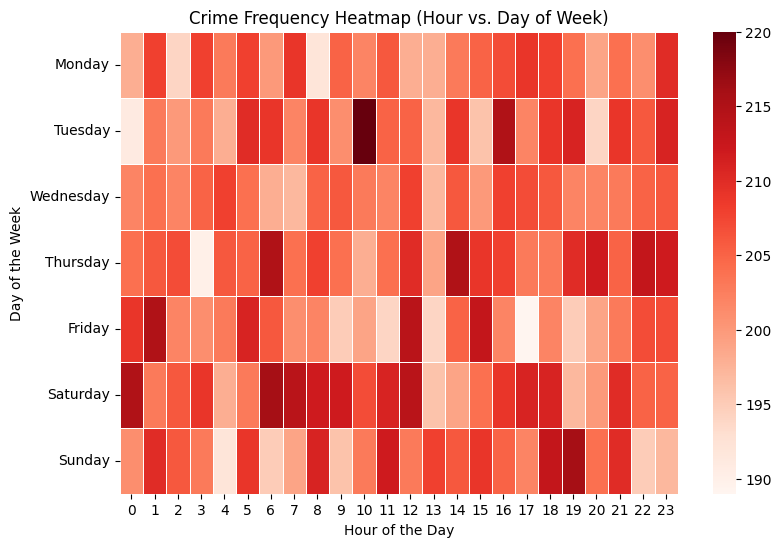

In [21]:
plt.figure(figsize=(9, 6))
sns.heatmap(heatmap_data, cmap="Reds", linewidths=0.5, annot=False)
plt.title("Crime Frequency Heatmap (Hour vs. Day of Week)")
plt.xlabel("Hour of the Day")
plt.ylabel("Day of the Week")
plt.show()
#Darker red areas indicate higher crime frequencies.

In [22]:
df['Weekend'] = df['DayOfWeek'].isin(['Saturday', 'Sunday']).astype(int)

In [23]:
df['TimeOfDay'] = df['Hour'].apply(lambda x: 'Nighttime' if (x >= 18 or x < 6) else 'Daytime')

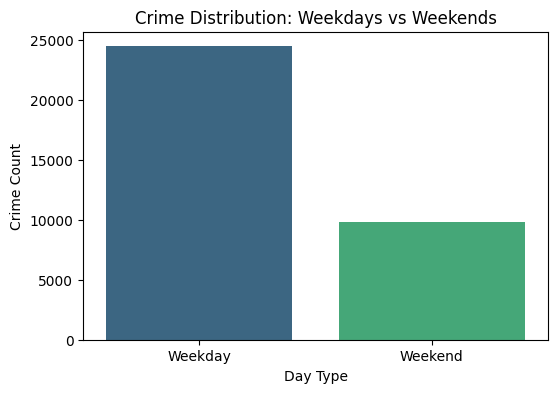

In [24]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Weekend', hue='Weekend', palette='viridis', legend=False)
plt.xticks(ticks=[0, 1], labels=['Weekday', 'Weekend'])
plt.title("Crime Distribution: Weekdays vs Weekends")
plt.xlabel("Day Type")
plt.ylabel("Crime Count")
plt.show()

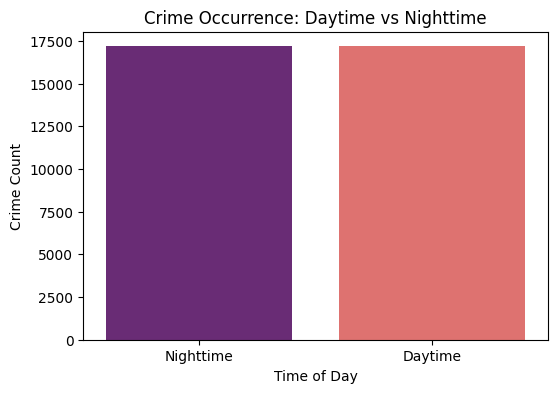

In [25]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='TimeOfDay', hue='TimeOfDay', palette='magma', legend=False)
plt.title("Crime Occurrence: Daytime vs Nighttime")
plt.xlabel("Time of Day")
plt.ylabel("Crime Count")
plt.show()

In [26]:
crime_counts = df.filter(like='Crime Description_').sum().sort_values(ascending=False)

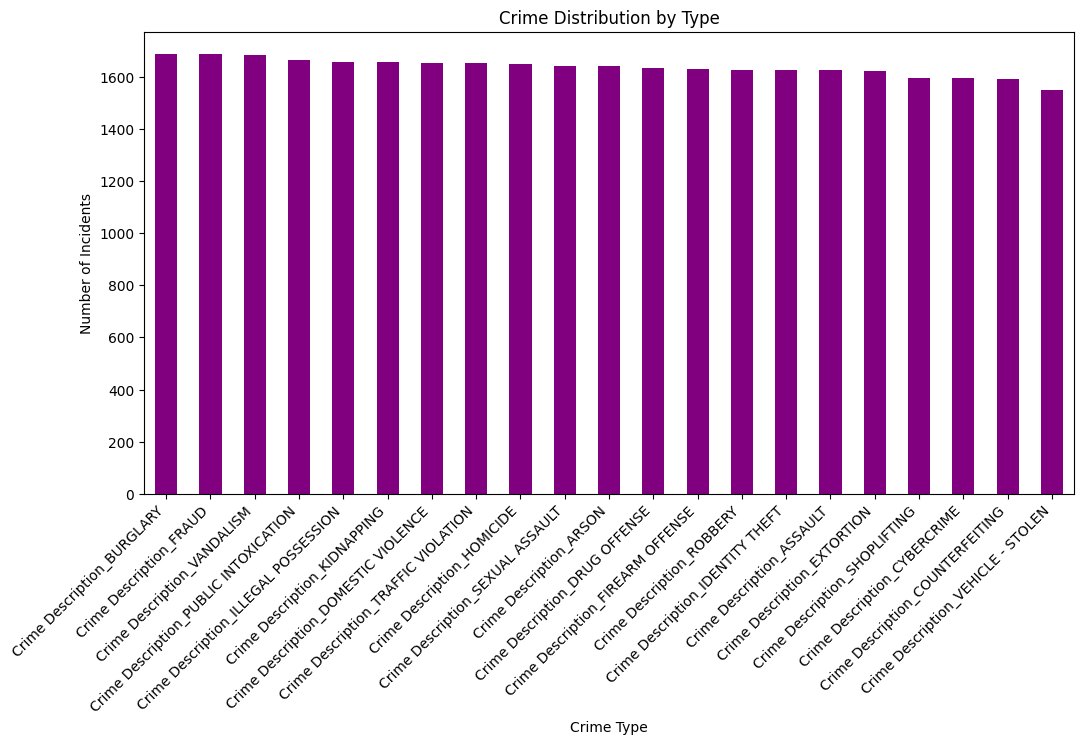

In [27]:
plt.figure(figsize=(12, 6))
crime_counts.plot(kind='bar', color='purple')
plt.xticks(rotation=45, ha="right") 
plt.xlabel("Crime Type")
plt.ylabel("Number of Incidents")
plt.title("Crime Distribution by Type")
plt.show()

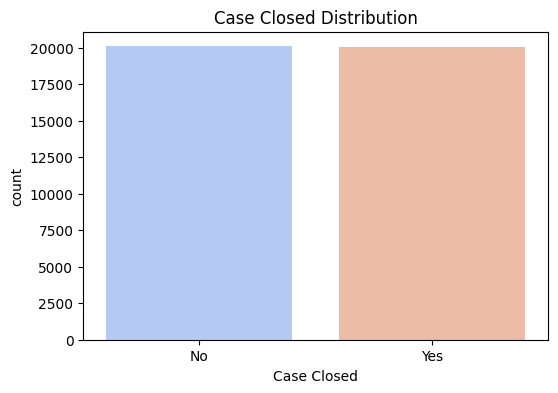

In [28]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Case Closed', hue='Case Closed', data=data, palette='coolwarm', legend=False)
plt.title("Case Closed Distribution")
plt.show()

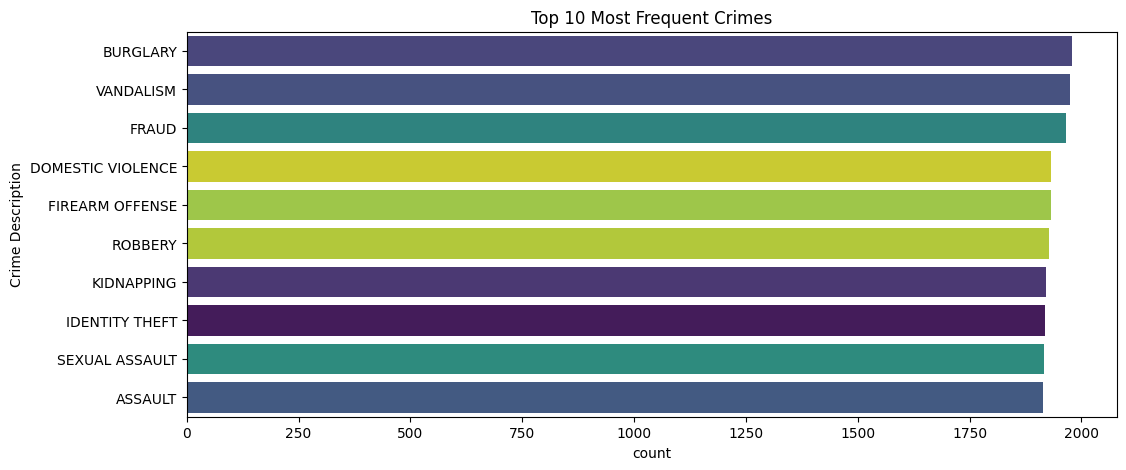

In [29]:
plt.figure(figsize=(12, 5))
sns.countplot(y='Crime Description', hue='Crime Description', data=data, 
              order=data['Crime Description'].value_counts().index[:10], 
              palette='viridis', legend=False)
plt.title("Top 10 Most Frequent Crimes")
plt.show()

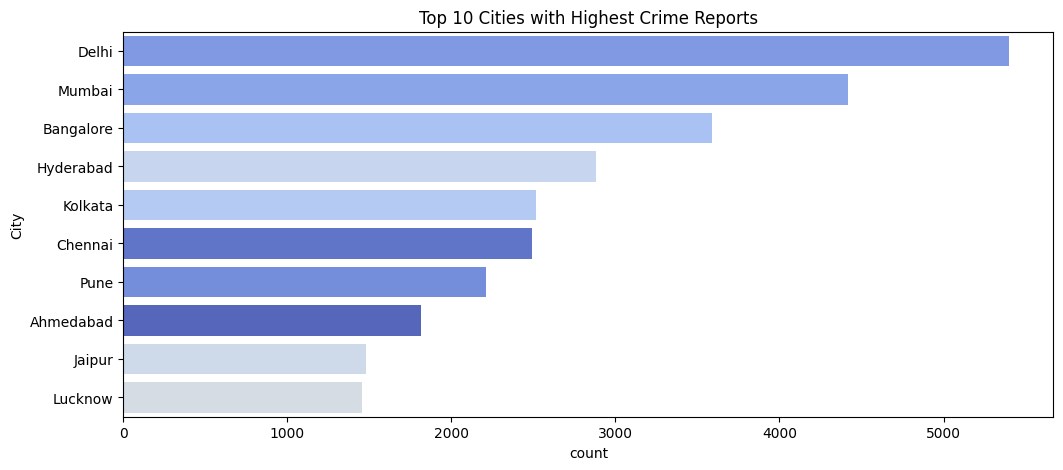

In [30]:
plt.figure(figsize=(12, 5))
sns.countplot(y='City', hue='City', data=data, 
              order=data['City'].value_counts().index[:10], 
              palette='coolwarm', legend=False)
plt.title("Top 10 Cities with Highest Crime Reports")
plt.show()

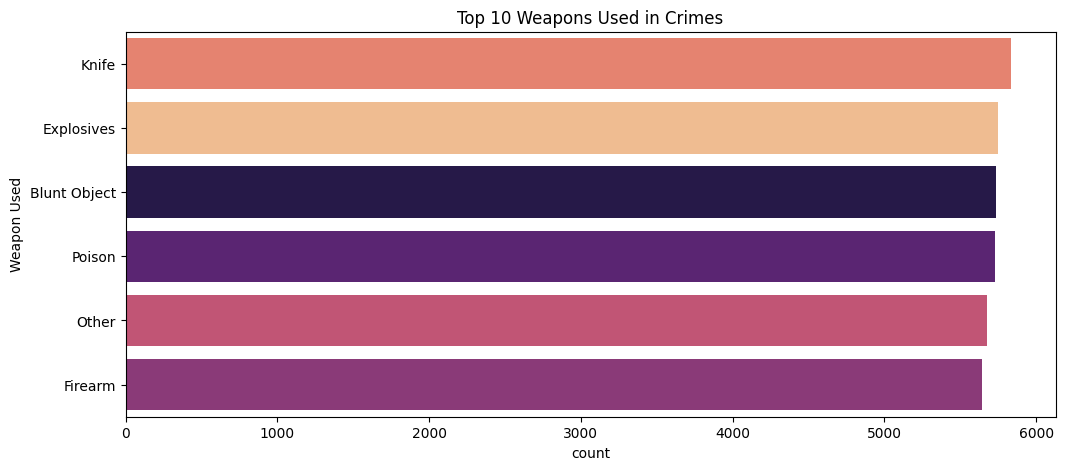

In [31]:
plt.figure(figsize=(12, 5))
sns.countplot(y='Weapon Used', hue='Weapon Used', data=data, 
              order=data['Weapon Used'].value_counts().index[:10], 
              palette='magma', legend=False)
plt.title("Top 10 Weapons Used in Crimes")
plt.show()

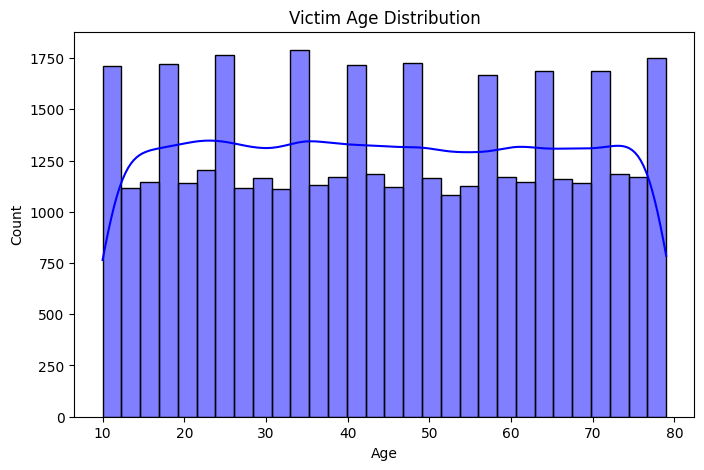

In [32]:
plt.figure(figsize=(8, 5))
sns.histplot(data['Victim Age'], bins=30, kde=True, color='blue')
plt.title("Victim Age Distribution")
plt.xlabel("Age")
plt.show()

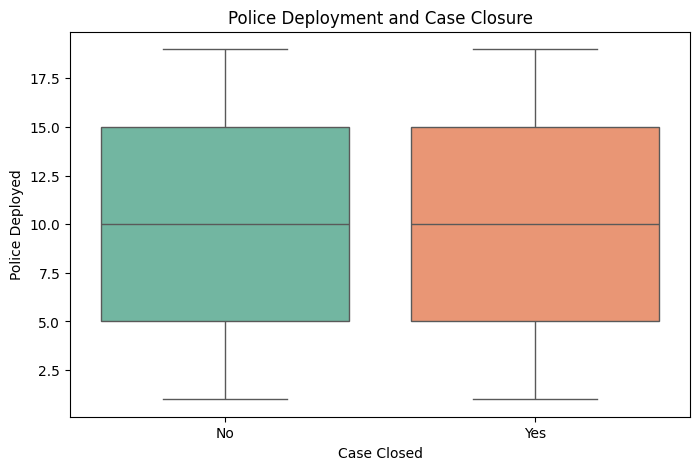

In [33]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='Case Closed', y='Police Deployed', data=data, hue='Case Closed', palette='Set2', legend=False)
plt.title("Police Deployment and Case Closure")
plt.show()

C:\Users\Lenovo'\AppData\Local\Temp\ipykernel_19620\3430252814.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Month'], palette='magma')


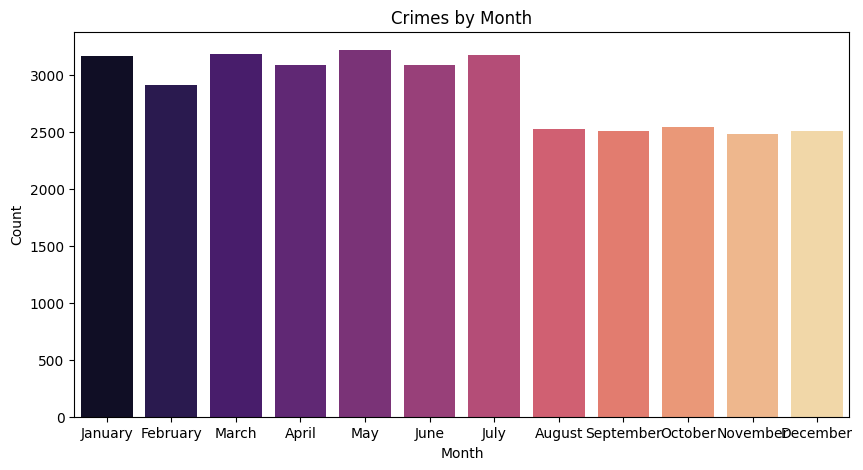

In [34]:
plt.figure(figsize=(10, 5))
sns.countplot(x=df['Month'], palette='magma')
plt.title("Crimes by Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.show()

In [35]:
label_encoders = {}
for col in ['City', 'Crime Description', 'Victim Gender', 'Weapon Used', 'Crime Domain', 'Case Closed']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

In [36]:
X = data.drop(columns=['Report Number', 'Case Closed', 'Date Reported', 'Date of Occurrence', 'Time of Occurrence', 'Date Case Closed'])
y = data['Case Closed']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [38]:
xgb = XGBClassifier(n_estimators=500)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

In [39]:
y_pred = xgb.predict(X_test)

In [40]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
xgb_accuracy = accuracy_score(y_test, y_pred)

Confusion Matrix:
 [[2061 1959]
 [2018 1994]]
Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.51      0.51      4020
           1       0.50      0.50      0.50      4012

    accuracy                           0.50      8032
   macro avg       0.50      0.50      0.50      8032
weighted avg       0.50      0.50      0.50      8032

Accuracy Score: 0.504855577689243


In [41]:
accuracy = accuracy_score(y_test, y_pred) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 50.49%


In [42]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, random_state=42)

In [43]:
y_pred = rf_model.predict(X_test)

In [44]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
rf_accuracy = accuracy_score(y_test, y_pred)

Confusion Matrix:
 [[2037 1983]
 [2066 1946]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.51      0.50      4020
           1       0.50      0.49      0.49      4012

    accuracy                           0.50      8032
   macro avg       0.50      0.50      0.50      8032
weighted avg       0.50      0.50      0.50      8032

Accuracy Score: 0.4958914342629482


In [45]:
accuracy = accuracy_score(y_test, y_pred) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 49.59%


In [46]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [47]:
svm_model = SVC(C=1.0, kernel='rbf', gamma='scale', random_state=42)

In [48]:
svm_model.fit(X_train, y_train)

SVC(random_state=42)

In [49]:
y_pred = svm_model.predict(X_test)

In [50]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
svm_accuracy = accuracy_score(y_test, y_pred)

Confusion Matrix:
 [[2007 2013]
 [2009 2003]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50      4020
           1       0.50      0.50      0.50      4012

    accuracy                           0.50      8032
   macro avg       0.50      0.50      0.50      8032
weighted avg       0.50      0.50      0.50      8032

Accuracy Score: 0.49925298804780877


In [51]:
accuracy = accuracy_score(y_test, y_pred) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 49.93%


In [52]:
label_encoders = {}
categorical_columns = ['City', 'Crime Description', 'Victim Gender', 'Weapon Used', 'Crime Domain', 'Case Closed']
for col in categorical_columns:
    if col in data.columns:
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le

In [53]:
feature_columns = [col for col in data.columns if col not in ['Report Number', 'Case Closed', 'Date Reported', 'Date of Occurrence', 'Time of Occurrence', 'Date Case Closed']]
X = data[feature_columns]
y = data['Case Closed']

In [54]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [55]:
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [57]:
lstm_model = Sequential()
lstm_model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(LSTM(50, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [58]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [59]:
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.4995 - loss: 0.6933 - val_accuracy: 0.4998 - val_loss: 0.6934
Epoch 2/10
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4991 - loss: 0.6933 - val_accuracy: 0.5050 - val_loss: 0.6932
Epoch 3/10
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5074 - loss: 0.6932 - val_accuracy: 0.5005 - val_loss: 0.6932
Epoch 4/10
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5011 - loss: 0.6931 - val_accuracy: 0.5002 - val_loss: 0.6932
Epoch 5/10
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.4996 - loss: 0.6932 - val_accuracy: 0.5020 - val_loss: 0.6933
Epoch 6/10
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5047 - loss: 0.6931 - val_accuracy: 0.4996 - val_loss: 0.6933
Epoch 7/10
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5072 - loss: 0.6929 - val_accuracy: 0.5054 - val_loss: 0.6932
Epoch 8/10
1004/1004 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5021 - loss: 0.6931 - 

In [60]:
y_pred = (lstm_model.predict(X_test) > 0.5).astype(int)

251/251 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [61]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
lstm_accuracy = accuracy_score(y_test, y_pred)

Confusion Matrix:
 [[1218 2802]
 [1250 2762]]
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.30      0.38      4020
           1       0.50      0.69      0.58      4012

    accuracy                           0.50      8032
   macro avg       0.49      0.50      0.48      8032
weighted avg       0.49      0.50      0.48      8032

Accuracy Score: 0.4955179282868526


In [62]:
accuracy = accuracy_score(y_test, y_pred) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 49.55%


In [63]:
model_names = ["Random Forest", "SVM", "XGBoost", "LSTM"]
accuracies = [rf_accuracy, svm_accuracy, xgb_accuracy, lstm_accuracy]
best_model_index = np.argmax(accuracies)

In [64]:
colors = ['blue', 'green', 'red', 'purple']
colors[best_model_index] = 'gold'

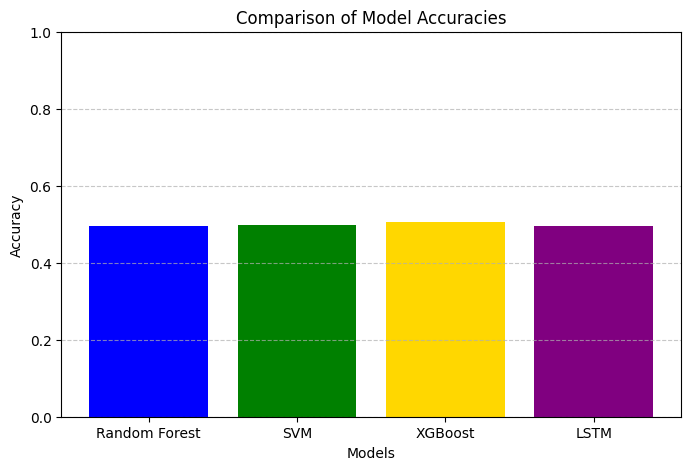

In [65]:
plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color=colors)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracies")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [66]:
print(f"The best model is {model_names[best_model_index]} with an accuracy of {accuracies[best_model_index]:.2f}")

The best model is XGBoost with an accuracy of 0.50


In [67]:
label_encoders = {}
for col in ['City', 'Crime Description', 'Victim Gender', 'Weapon Used', 'Crime Domain', 'Case Closed']:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

In [68]:
X = data.drop(columns=['Report Number', 'Case Closed', 'Date Reported', 'Date of Occurrence', 'Time of Occurrence', 'Date Case Closed'])
y = data['Case Closed']

In [69]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [70]:
X = X if hasattr(X, 'shape') else X.values

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [72]:
param_grid = {
    'n_estimators': [300, 500],
    'max_depth': [8, 10, 12],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'reg_alpha': [0, 0.5, 1.0],
    'reg_lambda': [0.5, 1.0, 1.5],
    'min_child_weight': [1, 3, 5],
    'scale_pos_weight': [1, 2, 3]
}

In [73]:
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='auc', use_label_encoder=False, random_state=42)

In [74]:
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 39366 candidates, totalling 118098 fits


E:\Anaconda\envs\freshenv\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:56:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=No...
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [8, 10, 12],
                         'min_child_weight': [1, 3, 5],
                         'n_estimators': [300, 500], 'reg_alpha': [0, 0.5, 1.0],
                         'reg_lambda': [0.5, 1.0, 1.5],
                         'scale_pos_weight': [1, 2, 3],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='accuracy', verbose=1)

In [75]:
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

Best parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 0.5, 'scale_pos_weight': 1, 'subsample': 0.7}
Best cross-validation accuracy: 0.5061941203993244


In [76]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [77]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test,y_pred))

Confusion Matrix:
 [[2067 1953]
 [2045 1967]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.51      0.51      4020
           1       0.50      0.49      0.50      4012

    accuracy                           0.50      8032
   macro avg       0.50      0.50      0.50      8032
weighted avg       0.50      0.50      0.50      8032

Accuracy Score: 0.5022410358565738


In [78]:
accuracy = accuracy_score(y_test, y_pred) * 100
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 50.22%


In [108]:
with open('model.pkl','wb') as file:
    pickle.dump(best_model,file)

In [4]:
with open('model.pkl', 'rb') as model_file:
        model = pickle.load(model_file)

In [ ]:
model.predict("Surat"